# 4. MLP応用 解説
## 概要
本演習ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装しました。<br>
演習問題文は<font color="Red">赤字</font>で表示されています。<br>

> テーマ
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>
>> [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)を利用します。<br>

## ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

## データの読み込み

In [ ]:
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root,
                                download=True,
                                train=True,
                                transform=transform)
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform)

train_dataloader = DataLoader(mnist_train,
                                batch_size=100,
                                shuffle=True)
test_dataloader = DataLoader(mnist_test,
                                batch_size=100,
                                shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.torch/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.torch/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.torch/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.torch/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/mnist/MNIST/raw



## 正則化（PyTorch）

### ドロップアウト
ドロップアウトとは、学習時に指定された割合のノードをランダムに消すテクニックであり、部分的なネットワークのアンサンブル学習として捉えることができます。これによって、表現力が高いMLPにおいても過学習を抑制することが可能になる場合あります。

ここでは、ドロップアウトのクラスをNumPyライブラリを用いて実装します。


<font color="Red">問1. 生成したrandommatrixがself.dropout_ratioより大きければTrue、そうでなければFalseを返すマスクを生成します。</font><br>



In [ ]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x, train_flg=True):
        if train_flg:
            randommatrix = np.random.rand(*x.shape)
            self.mask = randommatrix > self.dropout_ratio #### 問1 ####
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [ ]:
"""
class Dropout(nn.Module):
    def __init__(self, dropout_ratio = 0.2, training = True):
        super(Dropout, self).__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.training = training

    def forward(self, x):
        if self.training:
            randommatrix = torch.rand(*x.shape).to(device)
            self.mask = randommatrix > self.dropout_ratio ### 問1-1 ###
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio) ### 問1-2 ###

## or
class Dropout(nn.Module):
    def __init__(self, dropout_ratio = 0.2, training = True):
        super(Dropout, self).__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.training = training

    def forward(self, x):
        if self.training:
            randommatrix = torch.rand(*x.shape).to(device)
            self.mask = randommatrix > self.dropout_ratio
            return x * self.mask * (1.0 / (1.0 - self.dropout_ratio))
        else:
            return x
"""

#### <font color="Red">問1 解説</font>

まず、マスクについて説明します。例えば、```x```を以下のように定義したとします。

$$x=\left(
\begin{array}{cc} 
1 & 0 \\ -1 & 5 
\end{array}
\right)$$

この場合、```mask = (x <= 0)```を考慮すると、```mask```は以下の通りになります。

$$mask=\left(
\begin{array}{cc} 
False & True \\ True & False 
\end{array}
\right)$$

このように、条件に沿っているかをTrue・Falseで返す行列をmaskといいます。今回は、これを用いてコードを書いていきます。

今回の場合、条件に沿っているとTrueを返します。randommatrixがself.dropout_ratioより大きければTrueということが問題に書かれているため、```randommatrix > self.dropout_ratio```と書けば答えとなります。

従って、答えを```self.mask```とすると、次のようになります。

```
self.mask = randommatrix > self.dropout_ratio
```

また、PyTorchでDropoutを実装する場合は`torch.nn.Dropout()`が用いられます。

* <font color="Red">問2. PyTorchでDropoutを実装しましょう。</font>
  * <font color="Red">問2-1. 確率 `0.5` で出力を0にするDropoutのインスタンスを生成しましょう。</font>
  * <font color="Red">問2-2. 入力`input` に対し確率 Dropoutを適応する処理を記述しましょう。</font>


In [ ]:
torch.manual_seed(0)
input = torch.randn(3, 4)
print('入力: \n', input)

m = torch.nn.Dropout(p=0.5) ### 問2-1 ###
output = m(input) ### 問2-2 ###
print('Dropout後の出力: \n', output)

入力: 
 tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380],
        [-0.7193, -0.4033, -0.5966,  0.1820]])
Dropout後の出力: 
 tensor([[ 3.0820, -0.0000, -4.3576,  0.0000],
        [-2.1690, -2.7972,  0.0000,  1.6761],
        [-0.0000, -0.0000, -0.0000,  0.0000]])


#### <font color="Red">問2 解説</font>

まず、問2-1についてですが、Dropoutのインスタンスはpytorchのライブラリに含まれている```torch.nn.Dropout```を用いることで実装できます。

また、引数の1つとして```p```というものがあり、出力を0にする割合を0~1の間の数値で指定することができます。

従って、答えを```m```と表すと、次の通りになります。

```
m = torch.nn.Dropout(p=0.5)
```

次に問2-2についてです。問2-1によりDropoutのインスタンスを生成できたため、入力に対してDropoutを適応する処理を作成します。

問題2-1で作成したインスタンスに```input```を入力することで、Dropoutを適応することができます。

従って、答えを```output```とすると、次の通りになります。

```
output = m(input)
```

## パラメータノルムペナルティ

ノルムペナルティとは、モデルのパラメータが学習時に極端な値を取らないよう制限をかける手法です。

下記の式のように、損失関数にパラメータのLpノルム$||w||_{p}$を加えます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda||w||_{p}
$$

まずはLpノルム$||w||_{p}$を算出する関数を実装しましょう。また、以下ではテンソルに対するnumpyを用いた演算はエラーが生じる可能性がありますのでtorchを用いた演算を使いましょう。

* <font color="Red">問3. Lpノルムを算出する関数を完成させてください。</font>

In [ ]:
def lp_norm(w, p=2):
    return torch.sum(torch.abs(w)**p)**(1/p) ### 問3 ###

#### <font color="Red">問3 解説</font>

今回求めたのは、$||w||_{p}$ですが、これは次のように求めることができます。

$$ ||w||_{p} = (|w_{1}|^p + |w_{2}|^p + ... +|w_{n}|^p)^\frac{1}{p} $$

まず、絶対値はpytorchのライブラリにある```torch.abs```を用いて、```torch.abs(w)**p```で表すことができます。

次に、絶対値の和の部分は、pytorchのライブラリにある```torch.sum```を用いて、```torch.sum(torch.abs(w)**p)```と表すことができます。

最後に、絶対値の和を$\frac{1}{p}$乗すれば良いため、答えは次の通りになります。

```
torch.sum(torch.abs(w)**p)**(1/p)
```

次に、ラッソの損失を算出する関数を実装しましょう。

ラッソの損失はL1ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda\sum_{n=1}^D{|{w_n}|}
$$

* <font color="Red">問4. L1ノルム付き損失関数の$\lambda\sum_{n=1}^D{|w_n|}$を算出する関数を完成させてください。</font>

In [ ]:
def Lasso_loss(net, lam=0.001):
    loss = 0
    for params in net.parameters():#net.parameters()はネットワークの各層のパラメータを意味する
        loss += torch.sum(torch.abs(params))### 問4 ###
    return lam * loss

#### <font color="Red">問4 解説</font>

$\lambda\sum_{n=1}^D{|w_n|}$をコードで実装することができれば答えとなります。

ここで、$w$というのはネットワークの各層ごとのパラメータ、つまり```params```を表します。

つまり、Σの中身の絶対値は```torch.abs(params)```と表すことができます。求めたいのはこれの和なので、次の通りになります。

```
torch.sum(torch.abs(params))
```

また、$\lambda\sum_{n=1}^D{|w_n|}$は、ネットワークの各層のパラメータを表すため、```loss```という変数に値を加えていく必要があります。

そして$\lambda$を掛ける処理はreturnの```lam * loss```で表現できますね。従って、答えは次の通りになります。

```
loss += torch.sum(torch.abs(params))
```



次に、リッジ回帰を算出する関数を実装しましょう。

L2ノルム付き損失関数はL2ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}
$$

* <font color="Red">問5.  L2ノルム付き損失関数の$\frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}$を算出する関数を完成させてください。</font>

In [ ]:
def Ridge_loss(net, p=2, lam=0.001):
    loss = 0
    for params in net.parameters():#net.parameters()はネットワークの各層のパラメータを意味する
        loss += torch.sum(torch.abs(params)**p) ** (1/p) ### 問5 ###
    return (1/2) * lam * loss

#### <font color="Red">問5 解説</font>

まず、$w^2$について考えます。

今回、$w$は```params```と表されているため、$w^2$は、事前に準備されている```p=2```を用いて、```torch.abs(params)**p```と表されます。

今回求めたい部分は、```torch.abs(params)**p```の総和のルートであるため、次のように表すことができます。ルートの処理は式全体の$\frac{1}{2}$乗であることを利用しています。

```
torch.sum(torch.abs(params)**p) ** (1/p)
```

これを、ネットワークの各層のパラメータごとに足す必要があるため、```loss```に```torch.sum(torch.abs(params)**p) ** (1/p)```分だけ付け加える必要があります。

従って、答えは次のようになります。

```
loss += torch.sum(torch.abs(params)**p) ** (1/p) 
```

## ドロップアウトとL2ノルム正則化を含めたMLPの実装 (<u>ライブラリを使用しない</u>)

### 線形結合層などの定義

chapter02,chapter03演習のコードをPyTorchを用いて実装しているものであり、読み飛ばしていただいて構いません。

In [ ]:
# nn.Linearではなく、スクラッチの際に使用
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FullyConnectedLayer, self).__init__()
        self.in_features = input_dim  # 入力値の次元
        self.out_features = output_dim  # 出力値の次元

        weight = torch.randn(input_dim, output_dim) * 0.01
        bias = torch.randn(output_dim) * 0.01

        self.weight = nn.parameter.Parameter(weight)
        self.bias = nn.parameter.Parameter(bias)

    def forward(self, x):
        x = torch.mm(x, self.weight) + self.bias
        return x

In [ ]:
# nn.ReLUではなく、スクラッチの際に使用
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()
    
    def forward(self,x):
        mask = (x <= 0)
        x[mask] = 0
        return x

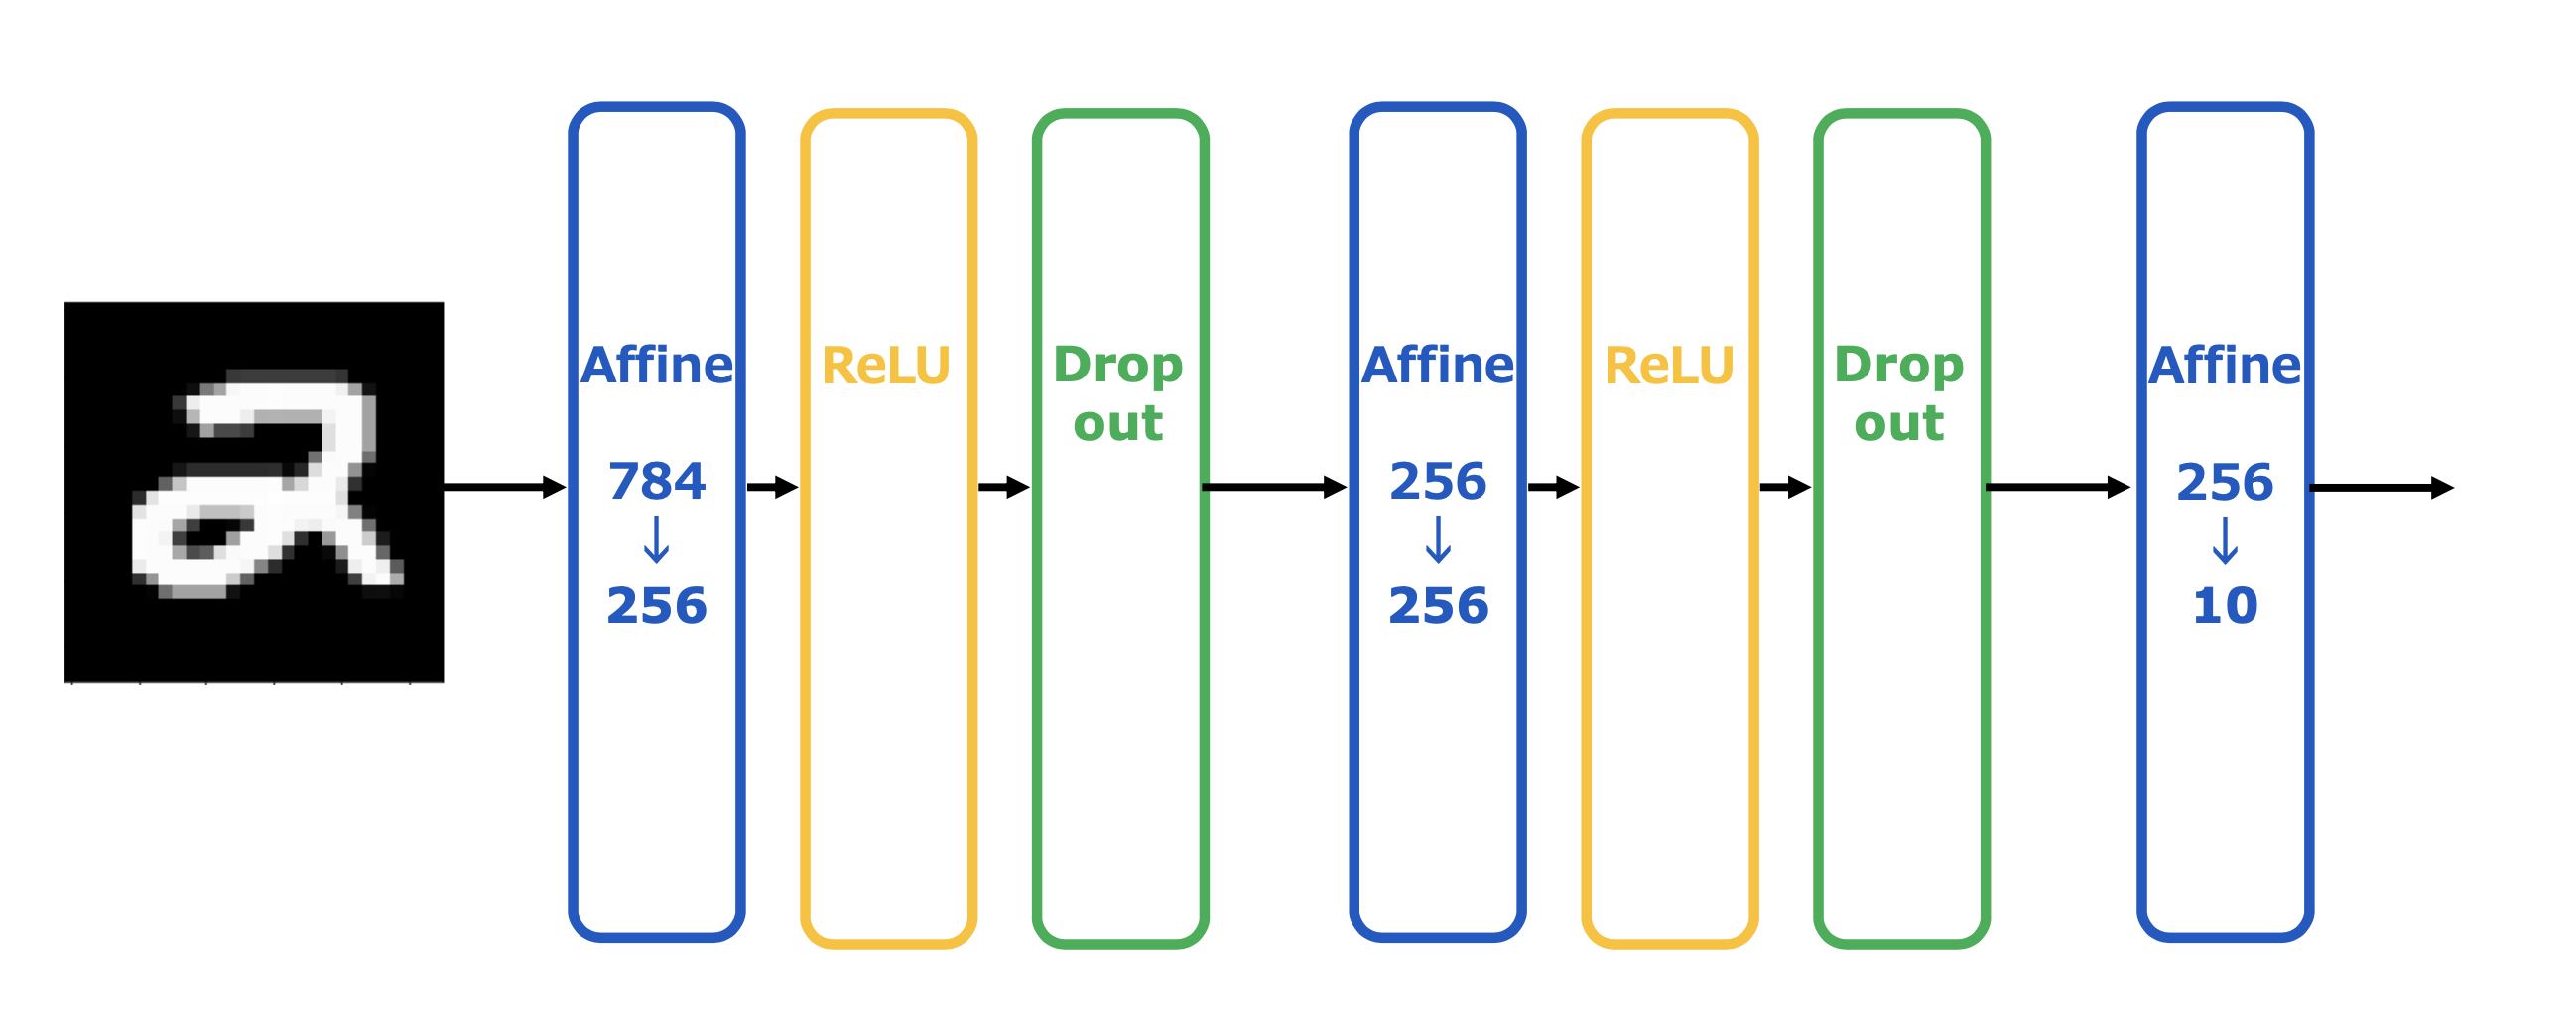


* <font color="Red">問6.ドロップアウトを含めたMLPクラスを完成させてください。</font><br>
    * <font color="Red">問6-1. 【forward関数】第1の全結合層の出力に対してドロップアウトを適応する処理を記述しましょう。</font><br>
    * <font color="Red">問6-2. 【forward関数】第2の全結合層に対してドロップアウトを適応する処理を記述しましょう。</font><br>

In [ ]:
class MLP_classifier(nn.Module):
    def __init__(self):
        '''
        構造
        x -> fc(784, 256) -> relu -> dropout -> fc(256, 256) -> relu -> dropout -> fc(256, 10) -> x
        '''
        super(MLP_classifier, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        '''
        順伝播
        '''
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x) ### 問6-1 ###
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x) ### 問6-2 ###
        x = self.fc3(x)

        return x

#### <font color="Red">問6 解説</font>

まず、問6-1についてです。

第2の全結合層の出力は次のように表されます。

```
x = self.relu1(self.fc1(x))
```

従って、ドロップアウトに適応させる変数は```x```であることが分かります。そのため、答えは次の通りになります。

```
x = self.dropout1(x)
```

次に、問題6-2についてです。

第2の全結合層の出力は次のように表されます。

```
x = self.relu2(self.fc2(x))
```

従って、ドロップアウトに適応させる変数は```x```であることが分かります。そのため、答えは次の通りになります。

```
x = self.dropout2(x)
```

### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。

* <font color="Red">問7. 問5で実装した`Ridge_loss`を使用して、損失関数に正則化項$\frac{\lambda}{2}\sqrt{{\sum_{n=1}^D{w_n^2}}}$を加えましょう。</font>

また、学習ステップとテストステップの手順を関数化します。

In [ ]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters())

def compute_loss(y, t, criterion=criterion):
    loss = criterion(y, t) + Ridge_loss(model) #### 問7 ###
    return loss

def train_step(x,t,model,optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def test_step(x,t,model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)
    return loss, preds

#### <font color="Red">問7 解説</font>

まず、損失関数は```criterion = nn.CrossEntropyLoss()```を指します。また、正則化項については問題5で作成した```Ridge_loss```を指します。

次に、```criterion```に入力する引数についてです。```criterion```には２つの引数を持ちます。

```
criterion(input,target)

- input : 入力値（入力画像やデータ）
- target : 目的変数

```

今回の場合、```input```は```y```が該当し、```target```は```t```が該当します。

従って、```criterion```については、```criterion(y,t)```と表すことができます。

次に、```Ridge_loss```に入力する引数についてです。これは、正則化項を実装したいモデルを入力すれば良いため、引数は```model```となります。

従って、答えは次のようになります。

```
loss = criterion(y, t) + Ridge_loss(model)
```


最後に学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います。

accuracyが95%前後になっていれば学習成功です。

In [ ]:
# 学習エポック数
epochs = 15
# epochs繰り返す
for epoch in range(epochs):

    train_loss = 0.
    test_loss = 0.
    train_acc = 0.
    test_acc = 0.

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    train_loss /= len(train_dataloader)
    train_acc /= len(mnist_train)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)

    print(f'epoch: {epoch+1},train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}')

epoch: 1,train loss: 0.44298, train acc: 0.87110, test loss: 0.16353, test acc: 0.95580
epoch: 2,train loss: 0.21437, train acc: 0.94157, test loss: 0.13027, test acc: 0.96530
epoch: 3,train loss: 0.17948, train acc: 0.95218, test loss: 0.11750, test acc: 0.97150
epoch: 4,train loss: 0.16455, train acc: 0.95715, test loss: 0.10673, test acc: 0.97510
epoch: 5,train loss: 0.14996, train acc: 0.96145, test loss: 0.10498, test acc: 0.97440
epoch: 6,train loss: 0.13754, train acc: 0.96593, test loss: 0.10517, test acc: 0.97560
epoch: 7,train loss: 0.13233, train acc: 0.96753, test loss: 0.10192, test acc: 0.97720
epoch: 8,train loss: 0.12927, train acc: 0.96842, test loss: 0.09558, test acc: 0.97780
epoch: 9,train loss: 0.12715, train acc: 0.97002, test loss: 0.09920, test acc: 0.97840
epoch: 10,train loss: 0.12230, train acc: 0.97172, test loss: 0.09766, test acc: 0.98070
epoch: 11,train loss: 0.11931, train acc: 0.97285, test loss: 0.10111, test acc: 0.97930
epoch: 12,train loss: 0.11791,

## データ拡張（PyTorch）

始めに`rabbit.jpg`の画像を読み込み、表示しましょう。

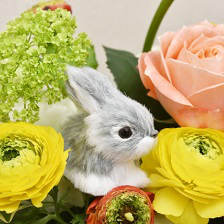

In [ ]:
img = Image.open("rabbit.jpg")
display(img)

### Random Flip

Random Flipは画像を反転させるデータ拡張方法です。ここでは、`RandomHorizontalFlip`と`RandomVerticalFlip`を実装します。

`RandomHorizontalFlip`は水平方向に確率`p`に従って反転させます。

`RandomVerticalFlip`は垂直方向に確率`p`に従って反転させます。

`RandomHorizontalFlip`や`RandomVerticalFlip`は以下のような引数を持ちます。

```
【引数】
  p : 画像を反転させる確率 (ex. p=0.5)
```

分かりやすさのため、ここでは確率を1として必ず反転した画像を出力します。
* <font color="Red">問8-1. `transforms.RandomHorizontalFlip`を用いて、水平方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>
* <font color="Red">問8-2. `transforms.RandomVerticalFlip`を用いて、垂直方向に確率`p=1`で反転させるデータ拡張を加えてください。</font>


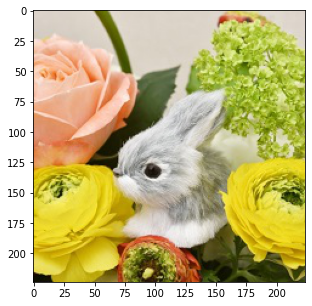

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=1.0) ### 問8-1 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問8-1 解説</font>

まず、```transforms.RandomHorizontalFlip```について説明します。

```transform```とは、データに対して行う前処理を行うオブジェクトのことを言います。前処理にも様々種類があるのですが、その一つとして```RandomHorizontalFlip```があります。

```RandomHorizontalFlip```とは、データを水平方向に反転させる関数です。また、反転する割合も決めることができ、引数として```p```という値を入力すれば決めることができます。

```p```は0~1の実数値を取り、何も入力しないと```p=0.5```（50％の確率で反転する）で反転します。

今回は、```p=1```と指定されているため、答えは次の通りになります。

```
transforms.RandomHorizontalFlip(p=1.0)
```

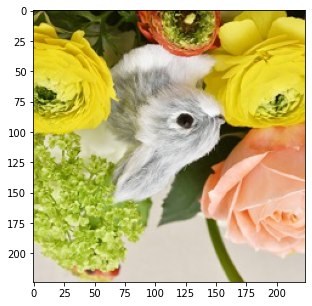

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomVerticalFlip(p=1.0) ### 問8-2 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問8-2 解説</font>

問題8-1と同じ要領で求めていきます。

問題8-1と異なるのは、使用する関数にあります。8-2では、```RandomVerticalFlip```というものを使用します。

```RandomVerticalFlip```とは、データを垂直方向に反転する関数です。```RandomHorizontalFlip```と同様に、反転する割合を決めることができます。

問題8-1と同じように考えると、今回は```p=1```と指定されているため、答えは次の通りになります。

```
transforms.RandomVerticalFlip(p=1.0)
```

### Erase

Eraseの中でも、`RandomErasing`を実装します。`RandomErasing`は画像の中の長方形領域をランダムに選択しそのピクセルを消去させるデータ拡張方法です。

`RandomErasing`は以下のような引数を持ちます。

```
【引数】
  p : 画像の一部を消去させる確率 (ex. p=0.5)
  scale : 入力画像に対する消去領域の比率の範囲 (ex. scale=(0.05, 0.06))
  ratio : 消去領域のアスペクト比の範囲 (ex. ratio=(0.3, 3.0))
  value : 消去に関するパラメータで、RGBチャンネルをそれぞれ消去する際は、長さ3のタプルを指定 (ex. value=0)
```

分かりやすさのため、ここでは確率を1として必ずある一部分が消去された画像を出力します。

* <font color="Red">問9. `transforms.RandomErasing`を用いて、確率`p=1`で画像内の長方形領域をランダムにピクセル消去させるデータ拡張を加えてください。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">入力画像に対する消去領域の比率の範囲を(0.02, 0.33)とします。</font>
  * <font color="Red">消去領域のアスペクト比の範囲を(0.3, 3.3)とします。</font>
  * <font color="Red">消去領域の色は黒(=0)とします。</font>

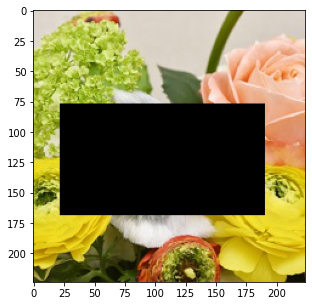

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0) ### 問9 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問9 解説</font>

transformsというライブラリの中には、```RandomErasing```という関数があります。```RandomErasing```とは、画像内からランダムに長方形領域を選択し、選択した領域を虫食い状態にする（隠す）実装を行う関数です。

```RandomErasing```にはいくつか引数があり

- ```p``` : ```RandomErasing```を実装する割合
- ```scale``` : 入力画像に対する消去領域の比率の範囲
- ```ratio``` : ```消去領域のアスペクト比の範囲```
- ```value``` : 消去領域の色（0の場合は黒）

となっております。

今回は、問題にそれぞれ指定されているため、それらを対応させたものが答えとなります。

従って、答えは次の通りになります。

```
transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
```

### Crop

Cropsは画像の切り取りによって得られるデータ拡張方法です。Cropsの中でも、`CenterCrop`を実装します。`CenterCrop`は与えられた画像を中央で切り取ります。

`CenterCrop`は以下のような引数を持ちます。

```
【引数】
  size : 切り取るサイズ (ex. size=300, size=(200, 300))
```

* <font color="Red">問10. `transforms.CenterCrop`を用いて、画像の中央を(224, 224)のサイズで切り取るデータ拡張を加えてください。</font>

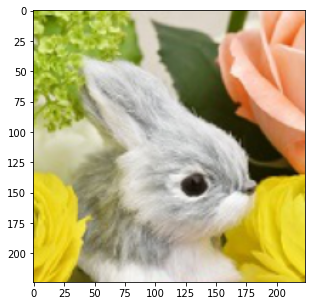

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose(
    [transforms.Resize(350),
     transforms.CenterCrop(224), ### 問10 ###
     transforms.ToTensor()
     ]
)
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問10 解説</font>

transformsというライブラリの中には、```CenterCrop```という関数が入っています。```CenterCrop```とは、画像の中央部分を切り取る関数です。

引数として、中央部分を中心として、どれくらいの大きさを切り取るかという変数を入力することができます。

今回は、(224,224)というサイズが指定されているため、答えは次の通りになります。

```
transforms.CenterCrop(224)
```

### Brightness

Brightnessは画像の明るさを変更させることによって得られるデータ拡張方法です。Brightnessの中でも、`ColorJitter`を実装します。`ColorJitter`は画像の明るさ、コントラスト、彩度、色合いをランダムに変化させます。<br>

`ColorJitter`は以下のような引数を持ちます。

```
【引数】
  brightness : 明るさを調整するパラメータ (ex. brightness=0.80)
  contrast : コントラストを調整するパラメータ (ex. contrast=0.80)
  saturation : 彩度を調整するパラメータ (ex. saturation=0.80)
  hue : 色合いを調整するパラメータ (ex. hue=0.60)
```

* <font color="Red">問11. `transforms.ColorJitter`を用いて、画像の明るさを変更させるデータ拡張を加えましょう。ただし、以下の条件を満たしてください。</font>
  * <font color="Red">明るさを0.75とします</font>
  * <font color="Red">コントラストを0.75とします</font>
  * <font color="Red">彩度を0.75とします</font>
  * <font color="Red">色合いを0.5とします</font>

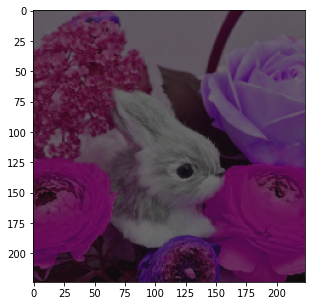

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75, hue=0.5) ### 問11 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問11 解説</font>

今回は、```ColorJitter```という関数を利用します。

```ColorJitter```とは、色の明るさ、コントラスト、彩度、色合いを変えることができる関数となっております。

引数については、次のようになっております。

- ```brightness``` : 明るさ
- ```contrast``` : コントラスト
- ```saturation``` : 彩度
- ```hue``` : 色合い

また、それぞれの引数に入力する値については、問題文に書かれているため、これを入力すれば良いです。

従って、答えは次のようになります。

```
transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75, hue=0.5)
```




### Rotate

Rotateは画像を回転させることによって得られるデータ拡張方法です。Rotateの中でも、`RandomRotation`を実装します。`RandomRotation`はランダムに画像を回転させます。

`RandomRotation`は以下のような引数を持ちます。

```
【引数】
  degrees : 選択する角度の範囲を指定するパラメータ (ex. degrees=60)
  expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
  fill : 回転した画像の外側の領域を埋める値 (ex. fill=255)
```

* <font color="Red">問12. `transforms.RandomRotation`を用いて、画像を90度回転させるデータ拡張を加えましょう。回転した画像の外側は黒色(=0)とし、出力画像は入力画像と同じ大きさにします。</font>

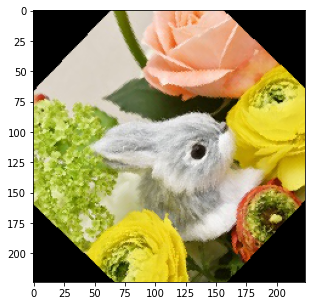

In [ ]:
img = Image.open("rabbit.jpg")
transform=transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomRotation(degrees=90, expand=False, fill=0) ### 問12 ###
])
img = transform(img)
img = img.numpy().reshape((3, 224, 224))
img = np.transpose(img,(1,2,0))

plt.figure(figsize=(5, 5))
plt.imshow(img)

#### <font color="Red">問12 解説</font>

今回は、```RandomRotation```という関数を利用します。

```RandomRotation```とは、ランダムにデータ（画像）を回転させることができる関数となっております。

引数については、次のようになっております。

```
- degrees : 選択する角度の範囲を指定するパラメータ
- expand : 拡張を実行するか決定するパラメータ。
           trueの場合、出力を拡大して、回転した画像全体を格納できる大きさにし、
           falseまたは省略された場合は、出力画像を入力画像と同じ大きさにする。
- fill : 彩度
```
また、それぞれの引数に入力する値については、問題文に書かれています。90度回転（```degrees=90```）、回転した画像の外側は黒色（```fill=0```）、出力画像は入力画像と同じ大きさ（```expand=False```）ということが分かります。

従って、答えは次のようになります。

```
transforms.RandomRotation(degrees=90, expand=False, fill=0) 
```

### MixUp

MixUpは2つの学習サンプルを混合して新たな学習サンプルを作成するデータ拡張手法です。

データとラベルのペア$(X_1, y_1)$と$(X_2, y_2)$から新たな学習サンプル$(X, y)$を作成します。ラベル$y_1, y_2$がone-hot表現の時、以下の式で$(X, y)$を作成します。

$$
X = \lambda X_1 + (1 - \lambda)X_2
$$
$$
y = \lambda y_1 + (1 - \lambda)y_2
$$

ここで、$\lambda$は0~1の範囲を取るパラメータで、ベータ分布$\beta(x,\alpha, \alpha)$からランダムにサンプリングします。$\alpha$はハイパーパラメータです。<br>
ベータ分布は以下のような確率密度関数として表すことができる。$C$は正規化定数。
$$
\beta(x,a,b) = C x ^ {a-1}(1-x) ^ {b-1}(0\leqq x\leqq 1)
$$


* <font color="Red">問13. MixUpにより新たな学習サンプルを作成しましょう。</font>
  * <font color="Red">問13-1. `np.random.beta()`関数を用いてベータ分布$\beta(\alpha, \alpha)$からサンプリングしましょう。</font>
  * <font color="Red">問13-2. パラメータ`lam`, 学習サンプル`x`, `x[index,:]`を使用して新たな学習データを算出する式を記述してください。</font>

In [ ]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
transform=transforms.Compose(
    [transforms.ToTensor(),
     ]
)
dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha) ### 問13-1 ###
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:] ### 問13-2 ###
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



target_a : 7
target_b : 6
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6294, 0.3706, 0.0000,
        0.0000])
lambda : 0.37061547061658573


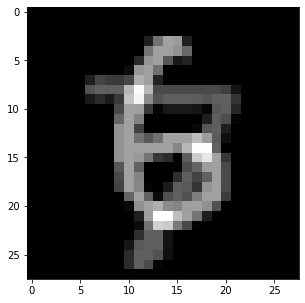

target_a : 3
target_b : 4
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.5503, 0.4497, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
lambda : 0.5503058575303685


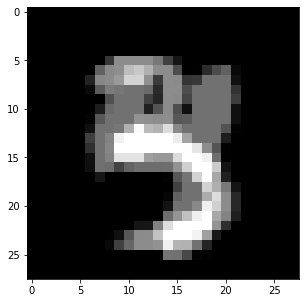

target_a : 7
target_b : 3
mixed_target_vector: tensor([0.0000, 0.0000, 0.0000, 0.6992, 0.0000, 0.0000, 0.0000, 0.3008, 0.0000,
        0.0000])
lambda : 0.30081220227043654


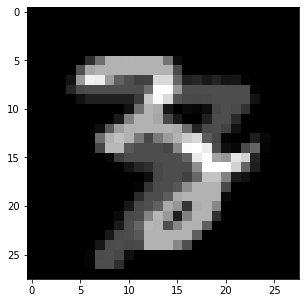

In [ ]:
counter = 0
for data, label in dataloader:
    mixed_data, target_a, target_b, lam = mixup_data(data, label, alpha=0.5, use_cuda=torch.cuda.is_available())
    counter += 1
    print(f'target_a : {target_a[0]}')
    print(f'target_b : {target_b[0]}')
    onehot_target_a = torch.eye(10)[target_a]
    onehot_target_b = torch.eye(10)[target_b]
    mixed_target_vector = onehot_target_a * lam + onehot_target_b * (1-lam)
    print(f'mixed_target_vector: {mixed_target_vector[0]}')
    print(f'lambda : {lam}')    
    img = mixed_data.numpy()[0].reshape((28, 28))
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.show()
    if counter == 3:
        break